# Part 2: Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path

  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")

get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from torch import optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F




"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

## Code (25 pt)

### 1. Implement Data Loader for training and validation (5 pt)

In [ ]:
from PIL import Image
import numpy as np
from torchvision import transforms

class VocDataset():
  def __init__(self, dir, color_map, image_transform=None, label_transform=None):
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map = np.array(color_map)
    self.label_transform = label_transform
    self.image_transform = image_transform


  def convert_to_segmentation_mask(self,mask):
    mask = np.array(mask)
    semantic_map = []
    for colour in self.color_map:
      equality = np.equal(mask, colour)
      class_map = np.all(equality, axis=-1)
      semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.argmax(semantic_map, axis=-1)

  def __getitem__(self,index):
    img_file = os.path.join(self.images_dir, self.files[index] + '.jpg')
    label_file = os.path.join(self.target_dir, self.files[index] + '.png')
    image = Image.open(img_file).convert("RGB")
    label = Image.open(label_file).convert("RGB")
    label = self.convert_to_segmentation_mask(label)
    if self.image_transform:
      image = self.image_transform(image)
    if self.label_transform:
      # label = self.label_transform(Image.fromarray(label.astype(np.uint8)))
      # label = transforms.Resize((256, 256))(label)  # Resize labels
      # label = torch.from_numpy(label)  # Convert labels to tensor
      label = Image.fromarray(label.astype(np.uint8))  # Convert to PIL Image
      label = transforms.Resize((256, 256))(label)  # Resize labels
      label = np.array(label)  # Convert back to numpy if necessary
      label = torch.from_numpy(label).long()  # Convert labels to tensor


    return image, label

  def __len__(self):
    return len(self.files)


# Transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to the same size
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Transformations for the labels
# label_transform = transforms.Compose([
#     transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize all labels to the same size
#     transforms.ToTensor()  # Convert labels to tensor
# ])



In [ ]:
# Assume the data is located in 'data/VOC'
dataset = VocDataset('/content', VOC_COLORMAP, image_transform=image_transform, label_transform=True)

# Training and Validation data loaders
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(dataset, batch_size=4, shuffle=True)

###2. Define model and training code (15 pt)
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [ ]:
import torch
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# The following implementation of FCN32 didn't work, I'm leaving it because:
##### If possible, please provide feedback why it didn't work. Thanks!
class FCN32(nn.Module):
    def __init__(self, n_classes, pretrained_model=True):
        super(FCN32, self).__init__()

        self.n_classes = n_classes

        # Load the pretrained VGG16 model
        vgg = models.vgg16(pretrained=pretrained_model)

        # Use the features portion of VGG16 (convolutional layers)
        features, classifier = list(vgg.features.children()), list(vgg.classifier.children())

        # Freeze the parameters of the VGG16 features
        for param in features:
            param.requires_grad = False

        self.features_map = nn.Sequential(*features)

        # Replace the last layer of VGG16 (which was used for classification)
        self.score_pool5 = nn.Conv2d(512, n_classes, kernel_size=1)

        # Create the upsampling layer that will allow us to create the final output
        self.upsample_32x = nn.ConvTranspose2d(n_classes, n_classes, 64, stride=32, bias=False)

        # Initialize the weights of the upsampling layer
        self.upsample_32x.weight.data.copy_(self.bilinear_kernel(n_classes, n_classes, 64))

    def forward(self, x):
        x = self.features_map(x)
        s = self.score_pool5(x)
        upsampled_output = self.upsample_32x(s)
        return upsampled_output[:, :, 19:19+x.size()[2], 19:19+x.size()[3]].contiguous()

    def bilinear_kernel(self, in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight)

# Instantiate the FCN32 model
fcn32 = FCN32(n_classes=len(VOC_CLASSES))
fcn32.to(device)  # Move the model to the GPU if available


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN32(
  (features_map): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
# Starting from here: The working implementation
# Get pretrained_model -> VGG16
encoder_net_vgg16 = models.vgg16(pretrained=True)
encoder_net_vgg16 = nn.Sequential(*list(encoder_net_vgg16.children()))[0]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 298MB/s]


In [ ]:
import torch.nn as nn
class FCN32(nn.Module):
  def __init__(self, n_classes, pretrained_model):
    super().__init__()
    self.pretrained_model = pretrained_model
    self.n_classes = n_classes
    self.relu = nn.ReLU(inplace=True)
    self.upconv1 = nn.ConvTranspose2d(512,512,kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.upconv5 = nn.ConvTranspose2d(64,32,kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    self.conv = nn.Conv2d(32,n_classes,kernel_size=1)


  def forward(self,x):
    '''
    VGG-16 has 5 max pools, each of them technically downsamples the feature map
    by 2^n, where n is the level of the max pool (1:5). So, the last Pool layer
    will have the effect of downsampling the H,W by 2^5, so we should be
    expexting a size=(N, 512, H/32, W/32)
    '''
    x = self.pretrained_model(x)
    x = self.bn1(self.relu(self.upconv1(x)))
    x = self.bn2(self.relu(self.upconv2(x)))
    x = self.bn3(self.relu(self.upconv3(x)))
    x = self.bn4(self.relu(self.upconv4(x)))
    x = self.bn5(self.relu(self.upconv5(x)))
    x = self.conv(x)

    return x      # Restored original size (N, n_classes, H, W)

fcn32 = FCN32(n_classes=21, pretrained_model=encoder_net_vgg16)
fcn32.to(device)  # Move the model to the GPU if available


FCN32(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn32.parameters(), lr=0.0001)

# Move the loss function to the GPU
criterion = criterion.to(device)

epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    fcn32.train()  # Set the model to training mode

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Training - Epoch {epoch+1}"):
        # Move the images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fcn32(images)

        # Up-sample the output to the size of the target
        outputs = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)

        # Squeeze the labels tensor from [batch_size, 1, height, width] to [batch_size, height, width]
        labels = labels.squeeze(1)
        labels = labels.long()

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f"Training loss: {running_loss/len(train_loader)}")

    # Validation loop
    fcn32.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(validation_loader, desc=f"Validation - Epoch {epoch+1}"):
            # Move the images and labels to the GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = fcn32(images)
            outputs = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

    print(f"Validation loss: {running_val_loss/len(validation_loader)}")

print('Finished Training')


Training - Epoch 1: 100%|██████████| 106/106 [01:04<00:00,  1.63it/s]


Training loss: 0.9496695534238275


Validation - Epoch 1: 100%|██████████| 106/106 [00:59<00:00,  1.77it/s]


Validation loss: 0.8202527873920944


Training - Epoch 2: 100%|██████████| 106/106 [01:04<00:00,  1.64it/s]


Training loss: 0.894955260011385


Validation - Epoch 2: 100%|██████████| 106/106 [00:59<00:00,  1.77it/s]


Validation loss: 0.7588192041752473


Training - Epoch 3: 100%|██████████| 106/106 [01:04<00:00,  1.64it/s]


Training loss: 0.8879643268180344


Validation - Epoch 3: 100%|██████████| 106/106 [00:59<00:00,  1.77it/s]


Validation loss: 0.7588334749892073


Training - Epoch 4: 100%|██████████| 106/106 [01:04<00:00,  1.65it/s]


Training loss: 0.834598312400422


Validation - Epoch 4: 100%|██████████| 106/106 [00:59<00:00,  1.77it/s]


Validation loss: 0.689521720386901


Training - Epoch 5: 100%|██████████| 106/106 [01:04<00:00,  1.65it/s]


Training loss: 0.7788876711197619


Validation - Epoch 5: 100%|██████████| 106/106 [01:00<00:00,  1.77it/s]


Validation loss: 0.6440061446068421


Training - Epoch 6: 100%|██████████| 106/106 [01:04<00:00,  1.64it/s]


Training loss: 0.7174293961165086


Validation - Epoch 6: 100%|██████████| 106/106 [01:00<00:00,  1.76it/s]


Validation loss: 0.5889761751552798


Training - Epoch 7: 100%|██████████| 106/106 [01:04<00:00,  1.63it/s]


Training loss: 0.6851464630860202


Validation - Epoch 7: 100%|██████████| 106/106 [01:00<00:00,  1.75it/s]


Validation loss: 0.5580684865983028


Training - Epoch 8: 100%|██████████| 106/106 [01:04<00:00,  1.64it/s]


Training loss: 0.6654543215936085


Validation - Epoch 8: 100%|██████████| 106/106 [01:00<00:00,  1.76it/s]


Validation loss: 0.534990520409818


Training - Epoch 9: 100%|██████████| 106/106 [01:05<00:00,  1.63it/s]


Training loss: 0.6261420308981301


Validation - Epoch 9: 100%|██████████| 106/106 [01:00<00:00,  1.76it/s]


Validation loss: 0.5099599790179504


Training - Epoch 10: 100%|██████████| 106/106 [01:05<00:00,  1.62it/s]


Training loss: 0.599413920967084


Validation - Epoch 10: 100%|██████████| 106/106 [00:59<00:00,  1.79it/s]

Validation loss: 0.4819242526900093
Finished Training


In [ ]:
# If got good results, Save net weights:
torch.save(fcn32.state_dict(), 'FCN32_model_weights.pth')

### 3. Inference for semantic segmentation (5 pt)

Implement the inference code for semantic segmentation. Display the visualization results of the model. Plot the image and colorized image (similar to the results in overview).

In [ ]:
# If saved the model: Load:
# fcn32 = FCN32(n_classes=21, pretrained_model=encoder_net_vgg16)
# fcn32.to(device)  # Move the model to the GPU if available
# fcn32.load_state_dict(torch.load('model_weights.pth'))


# Define color map
color_map = np.array(VOC_COLORMAP)

def inference(model, image_path, image_transform):
    model.eval()

    image = Image.open(image_path).convert("RGB")

    ### Plot Original as Resized ###
    original_image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Convert images to tensor
    ])
    # Apply transformations and convert to PIL Image for displaying
    transformed_image = original_image_transform(image)
    pil_transformed_image = transforms.ToPILImage()(transformed_image).convert("RGB")
    #######################

    image = image_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        output = F.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)

    preds = torch.argmax(output, dim=1)
    preds = preds.squeeze(0)
    preds = preds.cpu().numpy()

    # Print unique values in preds
    # print(np.unique(preds))

    # Map classes to colors
    color_image = color_map[preds]

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axs[0].imshow(pil_transformed_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Plot segmented image
    axs[1].imshow(color_image)
    axs[1].axis('off')
    axs[1].set_title('Segmented Image')

    plt.show()


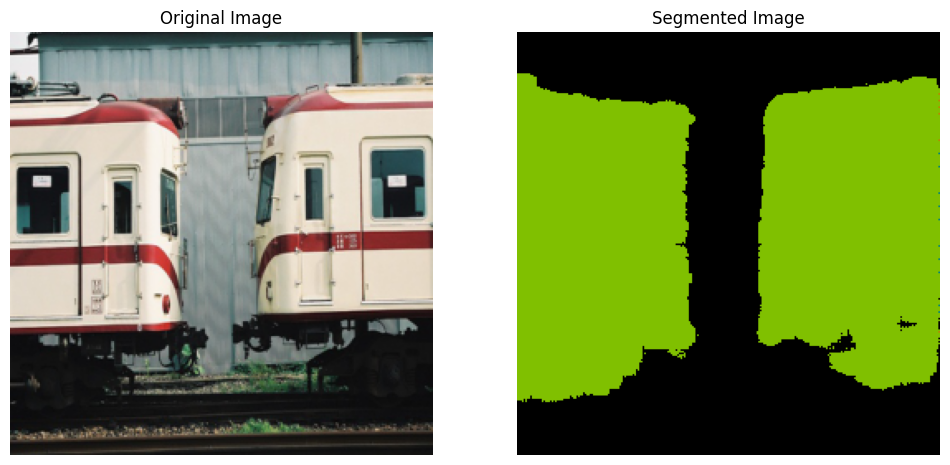

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000042.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

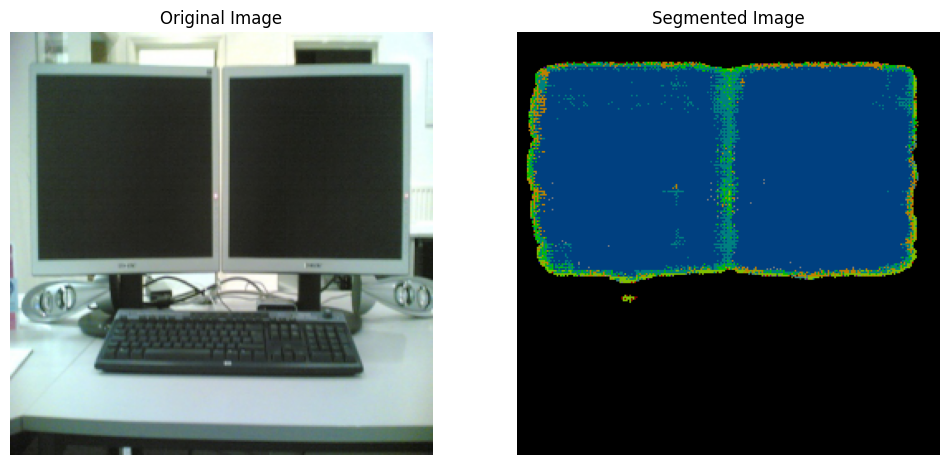

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000121.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

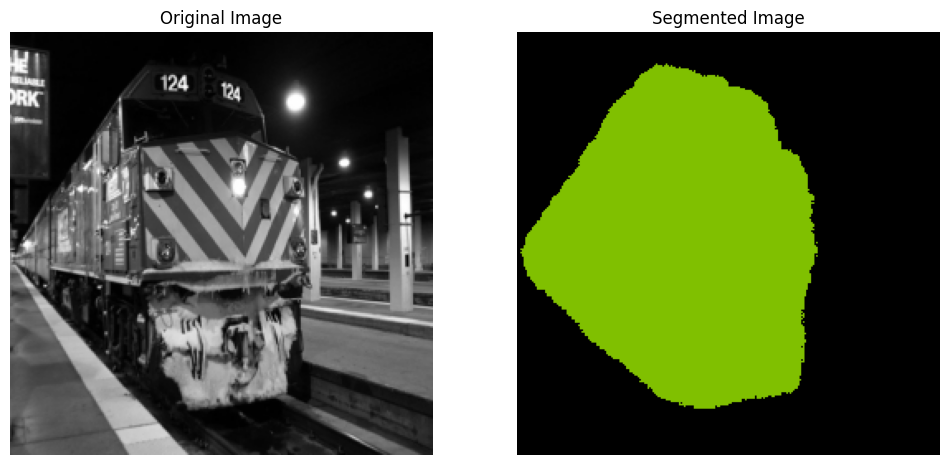

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000123.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

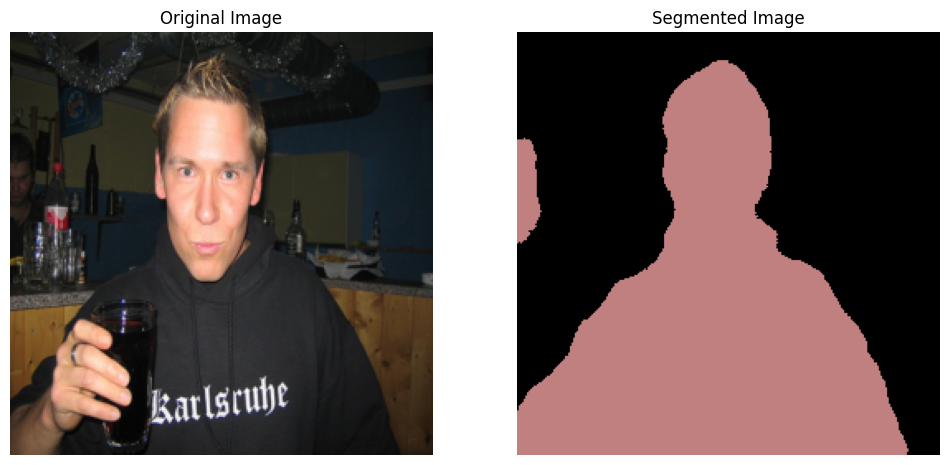

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000170.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

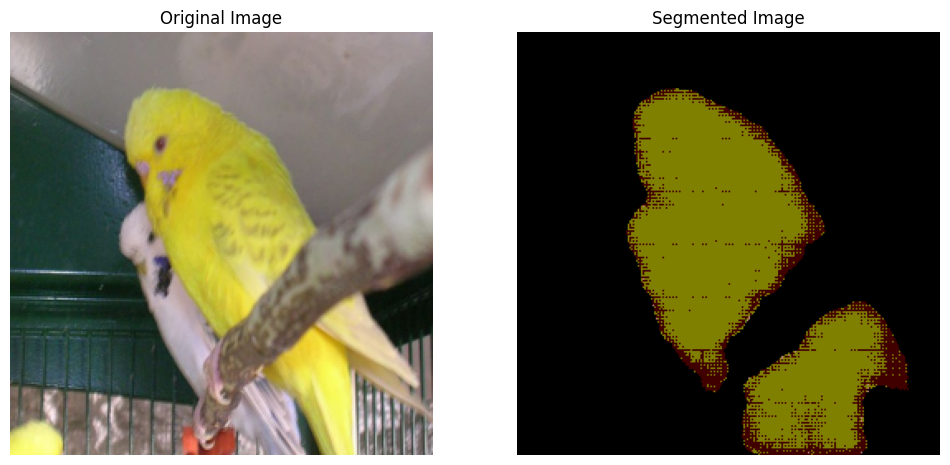

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000645.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

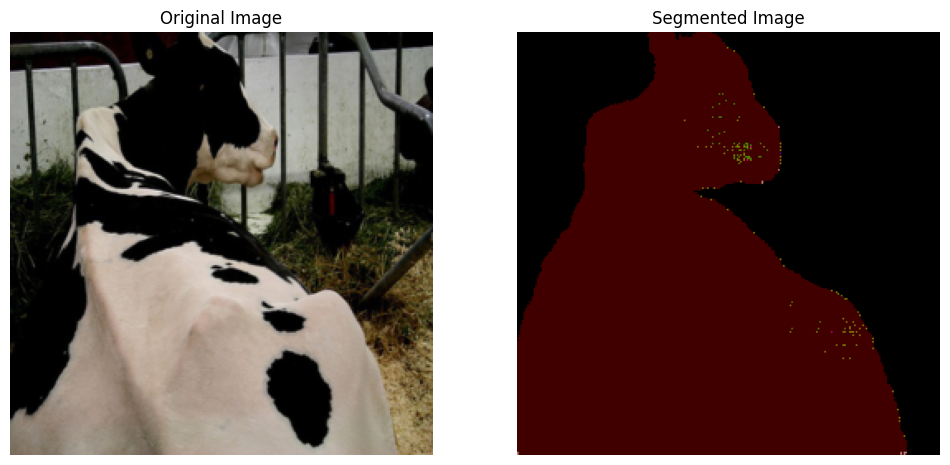

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000491.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

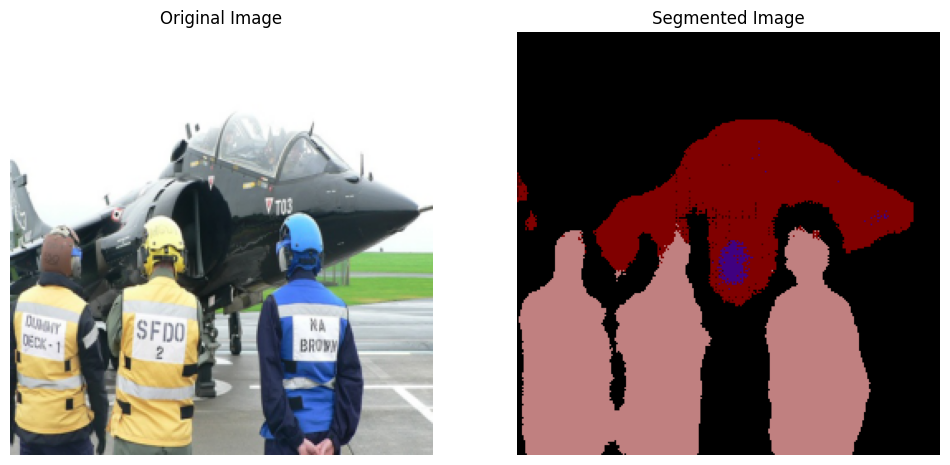

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000480.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

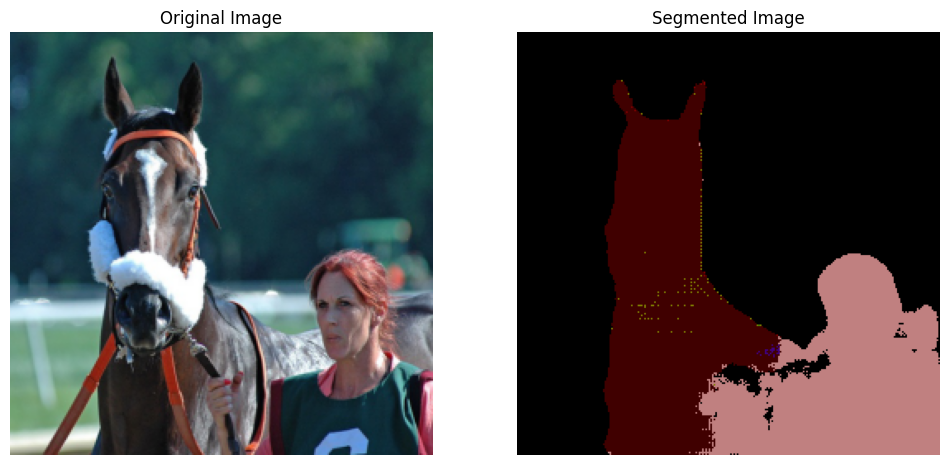

In [ ]:
image_path = '/content/VOCdevkit/VOC2007/JPEGImages/000799.jpg'
inference(fcn32, image_path=image_path, image_transform=image_transform)

## Write-up (5 pt)
* Describe the properties of segmentation model
* Describe the evaluation metric (IoU) for segmentation model

**Answer 1:**   

Summarizing from the FCN-32 paper:

Segmentation models are advanced deep learning architectures that provide detailed output by labeling each pixel in an image. These models are designed to understand image content at a deep level, identifying and categorizing every pixel. This task requires a robust set of training data, consisting of input images along with corresponding segmentation masks that label each pixel. There are various types of model architectures employed for this purpose, including U-Net, FCN, Mask R-CNN, and DeepLab. Evaluation of these models is unique and often relies on metrics such as Intersection over Union (IoU) and pixel accuracy. However, these models tend to be resource-intensive, demanding significant computational power, especially when dealing with high-resolution images.






**Answer 2**

Intersection over Union (IoU), is a widely used evaluation metric for segmentation models. It quantifies the overlap between the predicted segmentation and the ground truth, providing a measure of the quality of the model's predictions. For each class, IoU is calculated by dividing the area of overlap (Intersection) between the predicted and actual segmentations by the area encompassed by both these segmentations (Union). This results in a score between 0 and 1, where 1 signifies a perfect match between prediction and ground truth, and 0 indicates no overlap. A high average IoU across all classes signifies a well-performing model. It's worth noting that IoU is particularly effective as it penalizes both over-segmentation and under-segmentation, making it a balanced measure for model performance in segmentation tasks.






## Hint
* Refer to original paper FCNet : https://arxiv.org/abs/1411.4038
* Figures for FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch Tutorial for Image semgnetation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f